In [118]:
%load_ext autoreload
%autoreload 2
from src.data.data_loader import TwitterDataset, alphabet, get_loader
import pandas as pd
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence, pack_padded_sequence, pad_sequence, PackedSequence
from torch.nn import LSTM, Embedding, Module, Linear, ReLU, Sequential
from torch.utils.data import DataLoader, Sampler, RandomSampler, BatchSampler, SequentialSampler
import torch.nn as nn

# Import from 7.2 EXE
from torch.distributions import Distribution
from torch import Tensor

from src.models.common import cuda, EmbeddingPacked, get_variable, get_numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
batch_size = 100

data = pd.read_pickle('../data/interim/hydrated/200316.pkl')
        
dataset_train = TwitterDataset(data.iloc[:1000, :].copy())
dataset_validation = TwitterDataset(data.iloc[1500:2000, :].copy())

num_classes = len(alphabet)

train_loader = get_loader( dataset_train, batch_size )

In [106]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma * self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return torch.distributions.normal.Normal(self.mu, self.sigma).log_prob(z)

In [107]:
class Encoder1(nn.Module):

    def __init__(self, embedding_dim=64):
        super(Encoder1, self).__init__()

        self.n_features = len(alphabet)
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.embedding = EmbeddingPacked(
            num_embeddings = num_classes,
            embedding_dim = 10,
        )

        self.rnn1 = nn.LSTM(
            input_size=10,
            hidden_size=self.hidden_dim,
            num_layers=1,
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.embedding_dim,
            num_layers=1,
        )

    def forward(self, x):
        x = self.embedding(x)
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n

In [108]:
 class Encoder(nn.Module):

    def __init__(self, hidden_dim=64, num_layers=2):

        super(Encoder, self).__init__()

        self.num_layers = num_layers

        self.embedding = EmbeddingPacked(
            num_embeddings = num_classes,
            embedding_dim = 10,
        )

        self.rnn = nn.LSTM(
            input_size=10,
            hidden_size=hidden_dim,
            num_layers=self.num_layers,
        )

    def forward(self, x):

        x = self.embedding(x)
        x, (hidden_n, _) = self.rnn(x)

        return hidden_n[-1]

In [109]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim=64, max_length=290, num_layers=2):
        super(Decoder, self).__init__()

        self.max_length = max_length
        self.input_dim = input_dim
        self.n_features = len(alphabet)

        self.rnn = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.input_dim,
            num_layers=num_layers
        )

        self.output_layer = nn.Linear(self.input_dim, self.n_features)

    def forward(self, x):

        x = x.repeat(self.max_length, 1, 1)

        x, (_, _) = self.rnn(x)

        return self.output_layer(x)

In [120]:
class RecurrentVariationalAutoencoder(nn.Module):

    def __init__(self, embedding_dim=64, max_length = 290):

        super(RecurrentVariationalAutoencoder, self).__init__()
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(self.embedding_dim)
        self.decoder = Decoder(self.embedding_dim, max_length)

        self.hidden2mean = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.hidden2logv = nn.Linear(self.embedding_dim, self.embedding_dim)
        # MIGHT be different
        # https://github.com/timbmg/Sentence-VAE/blob/master/model.py
        self.latent2hidden = nn.Linear(self.embedding_dim, self.embedding_dim) 

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):

        x = self.encoder(x)

        # Reparameterize 
        mu = self.hidden2mean(x)
        log_var = self.hidden2logv(x)
        z = self.reparameterize(mu, log_var)

        # DECODER
        hidden = self.latent2hidden(z)
        x = self.decoder(hidden)

        return x

In [122]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from tqdm import tqdm

# Initialize a new network
rvae = RecurrentVariationalAutoencoder()

# Hyper-parameters
num_epochs = 10

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
criterion = CrossEntropyLoss(ignore_index=-1)
optimizer = SGD(rvae.parameters(), lr=0.001, momentum=0.9)

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    rvae.train()
    
    # For each sentence in training set
    for x in tqdm(train_loader):
        
        
        x = get_variable(x)
        
        # Forward pass
        # YOUR CODE HERE!
        output = rvae(x)
        
        # Compute loss
        # YOUR CODE HERE!
        loss = criterion(
            output.view(-1, 57),
            pad_packed_sequence(x, total_length=290, padding_value=-1)[0].view(-1)
        )
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(dataset_train))

100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


In [124]:
training_loss

[0.04028180646896362,
 0.040242916107177736,
 0.04018809986114502,
 0.04013356351852417,
 0.040068434238433835,
 0.04000666093826294,
 0.039949734687805175,
 0.039885089159011844,
 0.039826437473297116,
 0.039759542942047116]

In [125]:
test_loader = get_loader(TwitterDataset(data.iloc[5000:5005]), batch_size=5)
x = next(iter(test_loader))
results = rvae(x)

In [133]:
for i in range(5):
    print("".join([alphabet[i] for i in results.argmax(axis=2)[:,1]]))

In [128]:
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789,._´&’%\'":€$£!?#USE @'

In [137]:
pad_packed_sequence(x, total_length=300, padding_value=-1)[0].shape

torch.Size([300, 100])

In [135]:
output.shape

torch.Size([300, 100, 57])

In [132]:
pad_packed_sequence(x, total_length=300, padding_value=-1)

(tensor([[53, 53, 53,  ..., 53, 53, 53],
         [51,  8,  7,  ...,  8,  2, 24],
         [18, 55,  0,  ..., 55, 14,  4],
         ...,
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]]),
 tensor([272, 271, 271, 268, 261, 257, 252, 235, 233, 231, 228, 226, 225, 199,
         199, 197, 197, 196, 183, 178, 175, 173, 171, 169, 167, 166, 165, 164,
         162, 162, 154, 152, 151, 140, 126, 119, 117, 116, 116, 113, 112, 112,
         101, 100,  98,  98,  95,  91,  87,  85,  84,  84,  83,  82,  81,  80,
          79,  76,  75,  74,  72,  72,  72,  71,  70,  68,  65,  65,  64,  63,
          62,  61,  60,  59,  59,  59,  57,  56,  55,  54,  49,  48,  45,  43,
          43,  37,  37,  35,  34,  34,  27,  27,  26,  24,  22,  19,  14,  11,
           9,   6]))

In [122]:
pad_packed_sequence(x, total_length=300, padding_value=-1)


(tensor([[53, 53, 53,  ..., 53, 53, 53],
         [ 8,  8, 19,  ...,  0, 22,  8],
         [55, 19,  7,  ..., 12,  4,  5],
         ...,
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]]),
 tensor([281, 279, 278, 277, 277, 277, 269, 264, 256, 256, 254, 249, 246, 243,
         240, 239, 233, 230, 224, 213, 207, 206, 197, 192, 185, 177, 175, 167,
         166, 163, 161, 160, 157, 156, 150, 150, 133, 131, 127, 126, 123, 117,
         117, 107, 105, 103, 102, 101, 100, 100,  97,  95,  91,  88,  81,  79,
          79,  79,  79,  77,  75,  73,  73,  72,  70,  69,  68,  64,  57,  54,
          54,  54,  53,  52,  50,  46,  41,  39,  38,  37,  36,  35,  34,  34,
          34,  33,  31,  30,  29,  27,  27,  25,  25,  21,  21,  21,  18,  18,
          17,  16]))

/usr/local/Caskroom/miniconda/base/envs/deep-learning-vlae/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

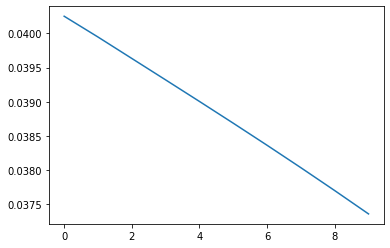

In [30]:
sns.lineplot()